## Introduction 
The main objective of this experiment is downloading crypto data (ETH) from Coinbase exchange, using CryptoCompare API.  Few additional analytical charts for ETH will be displayed later on.

## References and thanks to
- "Cryptocurrency Analysis with Python — MACD" (Part 1) by Roman Orac at the following [link;](https://towardsdatascience.com/cryptocurrency-analysis-with-python-macd-452ceb251d7c)
- "Cryptocurrency Analysis with Python — Buy And Hold" (Part 2) by Roman Orac at the following [link](https://towardsdatascience.com/cryptocurrency-analysis-with-python-buy-and-hold-c3b0bc164ffa);
- CryptoCompare API Documentation is available at [this link](https://min-api.cryptocompare.com/documentation);

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import requests
from datetime import datetime

In [ ]:
from_symbol = 'ETH'
to_symbol = 'USD'
exchange = 'Coinbase'
datetime_interval = 'day'

It is possible to download crypto data from other exchanges.  List of available exchanges at CryptoCompare can be found at the following [link;](https://www.cryptocompare.com/exchanges/#/overview) 

## Downloading crypto data

The [cryptocompare api](https://www.cryptocompare.com/api/#introduction) returns following columns: "open", "high", "low", "close", "volumefrom", "volumeto".

Let's download the data and store it to a file.

In [ ]:
def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals, 'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s / %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df


def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df

In [ ]:
# downloading ETH data:
data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Filtering 0 empty datapoints
Saving data to ETH_USD_Coinbase_day_2022-10-19.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


## Reading data

We read the data from a file so we don't need to download it again.

In [ ]:
def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)

Reading data from ETH_USD_Coinbase_day_2022-10-19.csv
(2001, 6)


##  Trading strategy

A trading strategy is a set of objective rules defining the conditions that must be met for a trade entry and exit to occur. 

We are going to apply Moving Average Convergence Divergence (MACD) trading strategy, which is a popular indicator used in technical analysis. 
MACD calculates two moving averages of varying lengths to identify trend direction and duration.
Then, it takes the difference in values between those two moving averages (MACD line) 
and an exponential moving average (signal line) of those moving averages.

As we can see in the example below:
- exit trade (sell) when MACD line crosses below the MACD signal line,
- enter trade (buy) when MACD line crosses above the MACD signal line. 

![]( http://www.onlinetradingconcepts.com/images/technicalanalysis/MACDbuysellaltNQ.gif "MACD")

## Calculate the trading strategy
We use [stockstats](https://github.com/jealous/stockstats) package to calculate MACD.

In [ ]:
!pip install stockstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(df)
df['macd'] = df.get('macd') # calculate MACD

stockstats adds the following columns to dataset:
- **macd** is MACD line,
- **macds** is signal line,
- **macdh** is MACD histogram.

In [ ]:
df.head()

,low,high,open,close,volumefrom,volumeto,macd,macds,macdh
datetime,,,,,,,,,
2017-04-28,62.50,74.90,63.67,73.14,439080.81,29764049.64,0.000000,0.000000,0.000000
2017-04-29,68.24,74.89,73.14,70.40,242005.37,17346942.58,-0.061474,-0.034152,-0.027322
2017-04-30,70.00,82.90,70.40,80.87,269888.42,20584476.48,0.246344,0.080805,0.165539
2017-05-01,72.24,85.21,80.87,79.35,416156.90,33480503.94,0.325429,0.163672,0.161757
2017-05-02,75.54,83.07,79.35,77.55,208582.40,16427688.06,0.289925,0.201230,0.088696


## Visualizing trading strategy 

We use bokeh interactive charts to plot the data.

The line graph shows daily closing prices with candlesticks (zoom in).
A candlestick displays the high, low, opening  and closing prices 
for a specific period. Tradeview has a great blogpost about 
[candlestick graph](https://www.investopedia.com/terms/c/candlestick.asp).

Below the line graph we plot the MACD strategy with MACD line (blue), signal line (orange) and histogram (purple).

In [ ]:
from math import pi

from bokeh.plotting import figure, show, output_notebook, output_file
output_notebook()

datetime_from = '2022-01-01 00:00'
datetime_to = current_datetime


def get_candlestick_width(datetime_interval):
    if datetime_interval == 'minute':
        #return 30 * 60 * 1000  # half minute in ms
        return 0.5 * 60 * 1000  # half minute in ms
    elif datetime_interval == 'hour':
        return 0.5 * 60 * 60 * 1000  # half hour in ms
    elif datetime_interval == 'day':
        return 12 * 60 * 60 * 1000  # half day in ms


df_limit = df[datetime_from: datetime_to].copy()
inc = df_limit.close > df_limit.open
dec = df_limit.open > df_limit.close

title = '%s datapoints from %s to %s for %s and %s from %s with MACD strategy' % (
    datetime_interval, datetime_from, datetime_to, from_symbol, to_symbol, exchange)
p = figure(x_axis_type="datetime",  plot_width=1000, title=title)

p.line(df_limit.index, df_limit.close, color='black')

# plot macd strategy
p.line(df_limit.index, 0, legend_label= '%s / %s' % (from_symbol, to_symbol), color='black')
p.line(df_limit.index, df_limit.macd, legend_label="MACD line", color='blue')
p.line(df_limit.index, df_limit.macds, legend_label="signal line", color='orange')
p.vbar(x=df_limit.index, bottom=[
       0 for _ in df_limit.index], top=df_limit.macdh, width=4, legend_label="histogram", color="purple")

# plot candlesticks
candlestick_width = get_candlestick_width(datetime_interval)
p.segment(df_limit.index, df_limit.high,
          df_limit.index, df_limit.low, color="black")
p.vbar(df_limit.index[inc], candlestick_width, df_limit.open[inc],
       df_limit.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df_limit.index[dec], candlestick_width, df_limit.open[dec],
       df_limit.close[dec], fill_color="#F2583E", line_color="black")

output_file("visualizing_trading_strategy.html", title="visualizing trading strategy")
show(p)

##Extract closing prices

In [ ]:
df = pd.DataFrame({'ETH': df.close})

In [ ]:
df.head()

,ETH
datetime,
2017-04-28,73.14
2017-04-29,70.40
2017-04-30,80.87
2017-05-01,79.35
2017-05-02,77.55


##Analysis: Basic Statistics

In [ ]:
df.describe()

,ETH
count,2001.000000
mean,1037.995682
std,1179.603053
min,70.400000
25%,207.110000
50%,388.760000
75%,1660.780000
max,4811.900000


###Let’s visualize ETH closing price data as box plot

We visualize the data in the table above with a box plot. A box plot shows the quartiles of the dataset with points that are determined to be outliers using a method of the inter-quartile range (IQR). In other words, the IQR is the first quartile (25%) subtracted from the third quartile (75%).

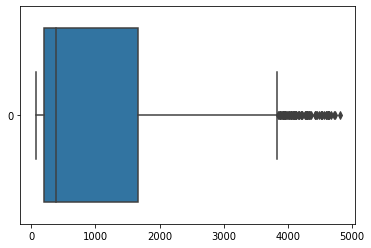

In [ ]:
import seaborn as sns
ax = sns.boxplot(data=df['ETH'], orient="h")

### Histogram of ETH closing price

Let’s estimate the frequency distribution of ETH closing prices. The histogram shows the number of hours ETH had a certain value.

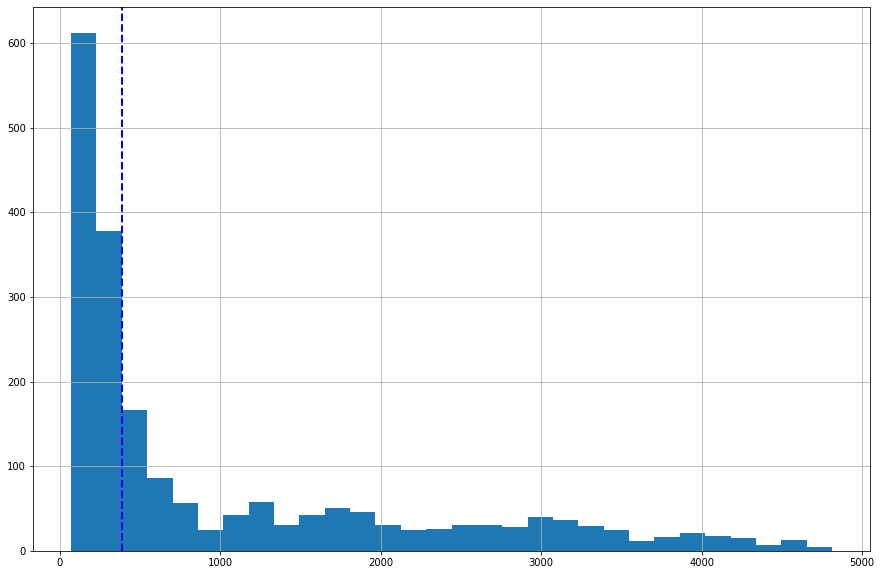

In [ ]:
df['ETH'].hist(bins=30, figsize=(15,10)).axvline(df['ETH'].median(), color='b', linestyle='dashed', linewidth=2)

### Visualize ETH absolute closing prices

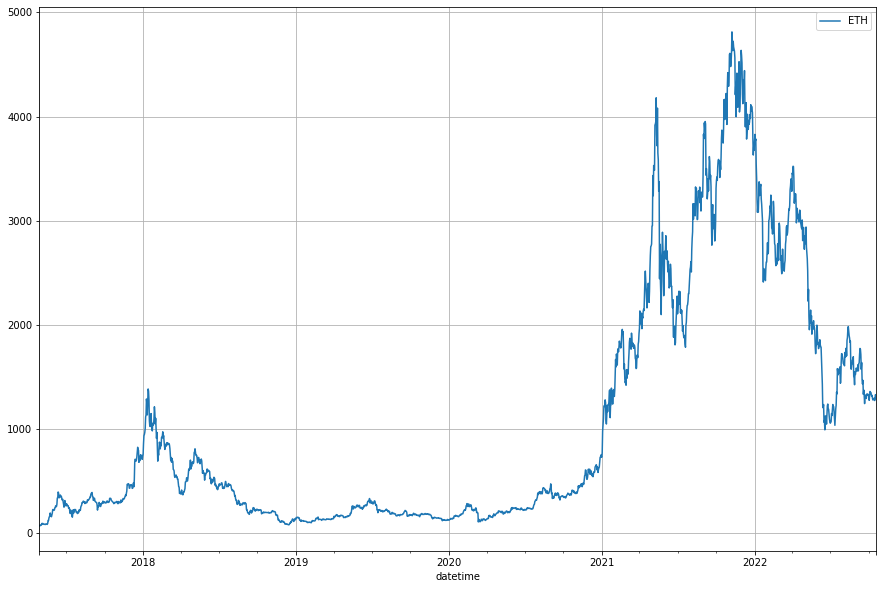

In [ ]:
df.plot(grid=True, figsize=(15, 10))